In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time
import pandas as pd


## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True

##### set parent directory

In [7]:
import os

# Get the current working directory
# current_directory = os.getcwd()
# # print("Current Directory:", current_directory)

# # Move to the parent directory
# parent_directory = os.path.dirname(current_directory)
os.chdir('/mnt/c/users/rjmay/code/research_ms/')
# Move to the parent directory





# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Updated Directory: /mnt/c/users/rjmay/code/research_ms


### Simulation stage

In [8]:
from modules.multi_bounds_v3 import bounds_class
from modules.knn_density import knn_num_calc
from modules.data_gen_mv import data_gen_multivariate


In [9]:
mean_sep = np.linspace(0, 5, 10000 , endpoint = True)


In [10]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 8 + dx, dx)
    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)
    fmin = np.minimum(f0, f1)
    BER = 0.5 * np.sum(fmin * dx)
    exact.append(BER)

#     print("BER 2d:", BER)

In [11]:
x = np.linspace(0,.5, 21, endpoint = True) ## this is the desired mean BER points to be calculated at 

new_mean_sep = [] 
for j in x:
    index = (np.abs(j - np.array(exact) )).argmin()
    new_mean_sep.append(mean_sep[index])

In [12]:
mean_sep = new_mean_sep

In [13]:
bound_obj_lst = []
bound_obj_lst2 = []


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:

    MC_num = 400
    sample_size= 500

    for i in mean_sep:

        start = time.time()
        dim =3 
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)
        
        func0 = np.random.multivariate_normal
        func1 = np.random.multivariate_normal


        params0 = {'mean': mean1, 'cov': covariance1}
        params1  = {'mean': mean2, 'cov': covariance2}

        generator = data_gen_multivariate(func0, func1,  params0, params1 )
        
        
        
        k = knn_num_calc(sample_size, len(mean1))


        bounds = bounds_class(generator, sample_size=  sample_size, threads =2,  MC_num = MC_num, k_nn=k)
        
        bound_obj_lst.append(bounds)

        
        print("done with 3d ", end = " ")
        dim = 8
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)

        
        
        
        params0  = {'mean': mean1, 'cov': covariance1}
        params1  = {'mean': mean2, 'cov': covariance2}

        generator = data_gen_multivariate(func0, func1,  params0, params1 )  
        
        k = knn_num_calc(sample_size, len(mean1))

        
        bounds2 = bounds_class(generator, sample_size = sample_size, threads =2,  MC_num = MC_num, k_nn =k )

        bound_obj_lst2.append(bounds2)
        
        
        end = time.time()
        
        print("done with ", i, " in ",  end -start )



USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [14]:
file_path = 'sim_data/means_sep_as_BER_v3.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst, bound_obj_lst2


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Loaded object successfully


## Using the data

may or not be pickled. 

In [15]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 8 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

#     print("BER 2d:", BER)

### Plotting using dim 3

In [16]:
df = pd.DataFrame([obj() for obj in bound_obj_lst], index = exact)


# df

In [17]:
fs = 14
dpi =300

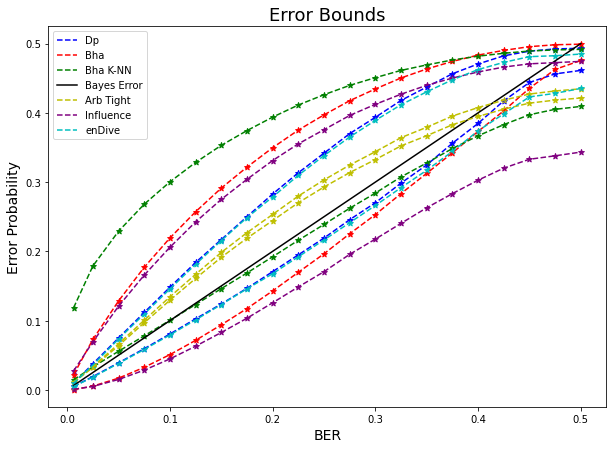

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))


# Plot Dp
ax.plot(df["Dp_lower"], 'b--', label='Dp')
ax.plot(df["Dp_upper"], 'b--')
ax.scatter(df.index, df["Dp_lower"], color='b', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='b', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'r--', label='Bha')
ax.plot(df["Bha_upper"], 'r--')
ax.scatter(df.index, df["Bha_upper"], color='r', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='r', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(exact, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'y--', label="Arb Tight")
ax.plot(df["tight_upper"], 'y--')
ax.scatter(df.index, df["tight_lower"], color='y', marker='*')
ax.scatter(df.index, df["tight_upper"], color='y', marker='*')

# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'purple', linestyle = '--', label="Influence")
ax.plot(df["inf_upper"], 'purple', linestyle = '--')
ax.scatter(df.index, df["inf_lower"], color='purple', marker='*')
ax.scatter(df.index, df["inf_upper"], color='purple', marker='*')


# Plot Lower and Upper enDive
ax.plot(df["enDive_lower"], 'c', ls = '--', label="enDive")
ax.plot(df["enDive_upper"], 'c', ls = '--',)
ax.scatter(df.index, df["enDive_lower"], color='c', marker='*')
ax.scatter(df.index, df["enDive_upper"], color='c', marker='*')


ax.set_xlabel("BER", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

# file_name = r"images/BER3"
# plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= 300)
plt.show()

BER plot

In [19]:
validity_lst  =[]
for i in range(len(exact)):
    validity_lst.append(bound_obj_lst[i].validity(exact[i]))
    
import pandas as pd
df = pd.DataFrame(validity_lst, index = exact)
# df

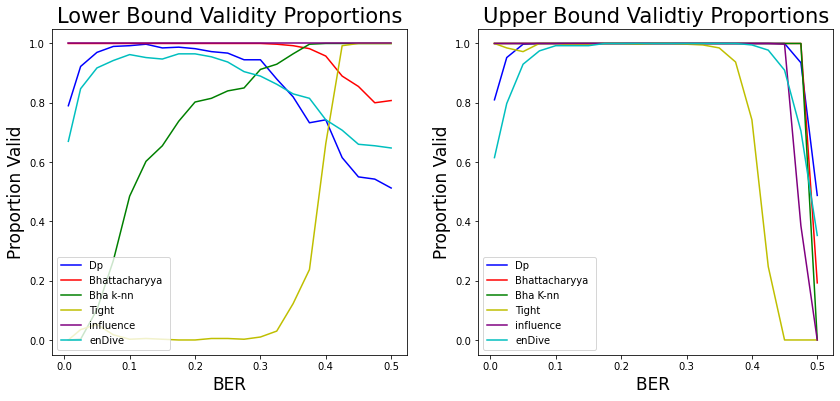

In [20]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df['Dp_lower'], 'b',  label='Dp')

ax.plot(df['Bha_lower'],'r', label='Bhattacharyya ')

ax.plot(df['Bha_knn_lower'],'g', label='Bha k-nn ')

ax.plot(df['tight_lower'], 'y', label='Tight ')

ax.plot(df['inf_lower'], 'purple', label= 'influence')

ax.plot(df['enDive_lower'], 'c', label= 'enDive')


ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend(loc=3)



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df['Dp_upper'], 'b',  label='Dp')

ax.plot(df['Bha_upper'],'r', label='Bhattacharyya ')

ax.plot(df['Bha_knn_upper'],'g', label='Bha K-nn ')

ax.plot(df['tight_upper'], 'y', label='Tight ')

ax.plot(df['inf_upper'], 'purple', label= 'influence')

ax.plot(df['enDive_upper'], 'c', label= 'enDive')

# ax.set_ylim([.4, 1.025])
# ax.set_yticks(np.linspace(.5,1,6))


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Upper Bound Validtiy Proportions" , fontsize = fs +4)
ax.legend(loc=3)


# plt.savefig("proportions_v2.jpeg",facecolor=(1,1,1,1))
plt.show()

### Plotting using dim 8 

In [21]:

df = pd.DataFrame([obj() for obj in bound_obj_lst2], index = exact)


In [22]:
dpi = 400
fs =17

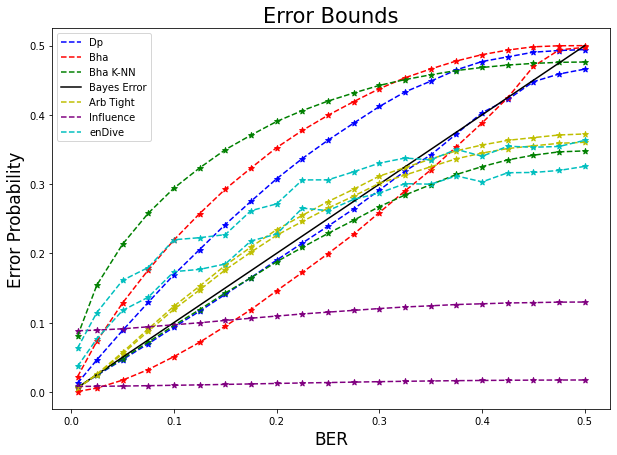

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))


# Plot Dp
ax.plot(df["Dp_lower"], 'b--', label='Dp')
ax.plot(df["Dp_upper"], 'b--')
ax.scatter(df.index, df["Dp_lower"], color='b', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='b', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'r--', label='Bha')
ax.plot(df["Bha_upper"], 'r--')
ax.scatter(df.index, df["Bha_upper"], color='r', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='r', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(exact, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'y--', label="Arb Tight")
ax.plot(df["tight_upper"], 'y--')
ax.scatter(df.index, df["tight_lower"], color='y', marker='*')
ax.scatter(df.index, df["tight_upper"], color='y', marker='*')

# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'purple', linestyle = '--', label="Influence")
ax.plot(df["inf_upper"], 'purple', linestyle = '--')
ax.scatter(df.index, df["inf_lower"], color='purple', marker='*')
ax.scatter(df.index, df["inf_upper"], color='purple', marker='*')


# Plot Lower and Upper enDive
ax.plot(df["enDive_lower"], 'c', ls = '--', label="enDive")
ax.plot(df["enDive_upper"], 'c', ls = '--',)
ax.scatter(df.index, df["enDive_lower"], color='c', marker='*')
ax.scatter(df.index, df["enDive_upper"], color='c', marker='*')


ax.set_xlabel("BER", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

file_name = r"images/BER8"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= 300)
plt.show()

In [24]:
# bound_obj_lst2[20].get_bounds_dp()[0]
    

In [25]:
len(bound_obj_lst2)


21

In [26]:
validity_lst  =[]
for i in range(len(exact)):
    validity_lst.append(bound_obj_lst2[i].validity(exact[i]))
    
import pandas as pd
df = pd.DataFrame(validity_lst, index = exact)
df

,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper,inf_lower,inf_upper,enDive_lower,enDive_upper,Dp,Bha,Bha_knn,tight,inf,enDive
0.006210,0.5300,0.9525,1.0000,1.0,0.3575,1.000,0.8925,0.1600,1.0,0.0,1.0000,0.5000,0.5075,0.4825,1.0000,0.3575,0.0525,0.0000,0.0075
0.025001,0.5975,1.0000,1.0000,1.0,0.5825,1.000,0.5400,0.5525,1.0,1.0,1.0000,0.5000,0.5475,0.5975,1.0000,0.5825,0.0925,1.0000,0.0475
0.049994,0.6775,1.0000,1.0000,1.0,0.6975,1.000,0.3450,0.7375,1.0,1.0,1.0000,0.4950,0.5525,0.6775,1.0000,0.6975,0.0825,1.0000,0.0475
0.074984,0.7475,1.0000,1.0000,1.0,0.7475,1.000,0.1550,0.9075,1.0,1.0,1.0000,0.5025,0.5650,0.7475,1.0000,0.7475,0.0625,1.0000,0.0675
0.099987,0.7500,1.0000,1.0000,1.0,0.7600,1.000,0.0875,0.9575,1.0,1.0,0.0375,0.4800,0.6175,0.7500,1.0000,0.7600,0.0450,0.0375,0.0975
0.124997,0.8025,1.0000,1.0000,1.0,0.8250,1.000,0.0850,0.9550,1.0,1.0,0.0000,0.5275,0.5825,0.8025,1.0000,0.8250,0.0400,0.0000,0.1100
0.150019,0.7975,1.0000,1.0000,1.0,0.7525,1.000,0.0850,0.9550,1.0,1.0,0.0000,0.5550,0.5775,0.7975,1.0000,0.7525,0.0400,0.0000,0.1325
0.174999,0.7600,1.0000,1.0000,1.0,0.8625,1.000,0.0600,0.9800,1.0,1.0,0.0000,0.5225,0.6100,0.7600,1.0000,0.8625,0.0400,0.0000,0.1325
0.200010,0.7800,1.0000,1.0000,1.0,0.8850,1.000,0.0625,0.9700,1.0,1.0,0.0000,0.5350,0.6075,0.7800,1.0000,0.8850,0.0325,0.0000,0.1425
0.225027,0.7350,1.0000,1.0000,1.0,0.9500,1.000,0.1200,0.9450,1.0,1.0,0.0000,0.4700,0.6475,0.7350,1.0000,0.9500,0.0650,0.0000,0.1175


In [27]:
# print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

Upper bound Validity

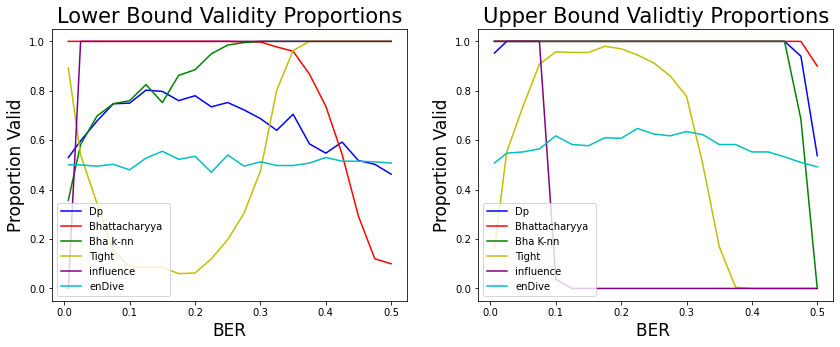

In [28]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df['Dp_lower'], 'b',  label='Dp')

ax.plot(df['Bha_lower'],'r', label='Bhattacharyya ')

ax.plot(df['Bha_knn_lower'],'g', label='Bha k-nn ')

ax.plot(df['tight_lower'], 'y', label='Tight ')

ax.plot(df['inf_lower'], 'purple', label= 'influence')

ax.plot(df['enDive_lower'], 'c', label= 'enDive')


ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend(loc=3)



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df['Dp_upper'], 'b',  label='Dp')

ax.plot(df['Bha_upper'],'r', label='Bhattacharyya ')

ax.plot(df['Bha_knn_upper'],'g', label='Bha K-nn ')

ax.plot(df['tight_upper'], 'y', label='Tight ')

ax.plot(df['inf_upper'], 'purple', label= 'influence')

ax.plot(df['enDive_upper'], 'c', label= 'enDive')

# ax.set_ylim([.4, 1.025])
# ax.set_yticks(np.linspace(.5,1,6))


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Upper Bound Validtiy Proportions" , fontsize = fs +4)
ax.legend(loc=3)

file_name = r"images/gauss_validity8"
# plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= 300)
plt.show()